In [ ]:
!pip install matplotlib==3.5.2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from functools import reduce, partial # fixes some of the arguments
import itertools
import math

import matplotlib
assert matplotlib.__version__ == '3.5.2' # if not, need to restart kernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1

In [ ]:
def get_files(path='/content/drive/My Drive/packets_data', names=('D_vals.csv', 'F_vals.csv', 'DB_with_mono_full.csv', 'DB_no_mono_full.csv')):
    """
    по дефолту - ищется в папке 'packets_data', лежащей в корне гугл-диска
    файлы надо перетащить через иконку с файлами в колабе, чтобы gdrive не поменял расширения у файлов
    """
    return tuple(pd.read_csv(os.path.join(path, name)) for name in names)

In [ ]:
new_names = {
    'D':{'Показатель'       :'Indicator_D', 
         'Результат_D'      :'Result_D'},

    'F':{'Дата результата'  :'ResultDate_F',
         'Дата взятия'      :'TakingDate_F',
         'Показатель_F'     :'Indicator_F',
         'Результат'        :'Result_F'},
    
    'no_mono':{'Vac'        :'Vacin',
               'Start'      :'StartTher',
               'End'        :'EndTher'},
    'with_mono':{'Start'    :'StartTher',
                 'End'      :'EndTher'}
}

to_cat = lambda t: t.astype('category')
to_date = partial(pd.to_datetime, dayfirst=True, errors='coerce')
to_num = partial(pd.to_numeric, errors='coerce') # replace bad numbers with nan
cast_functions = {
    'Indicator_D':to_cat,
    'Result_D': lambda t: to_num(t.replace('>3000', '3000')),
    'ResultDate_F': to_date,
    'TakingDate_F': to_date,
    'Indicator_F': to_cat,
    'Result_F': to_num,
    'CaseID': lambda t: t.astype(pd.Int64Dtype()),
    'StartTher': to_date,
    'EndTher': to_date,
    'Gender': to_cat,
    'Ther': to_cat,
    'Outcome': to_cat,
    'Vacin': to_cat,
}

date_fields = {'D':'CaseID', # because no date field in D
               'F': 'ResultDate_F',
               'no_mono': 'StartTher',
               'with_mono': 'StartTher',}

In [ ]:
def task_1():
    D, F, with_mono, no_mono = get_files()
    tables = {'D': D, 'F':F, 'no_mono':no_mono, 'with_mono':with_mono}

    # last columns don't have any data
    D.drop(columns=D.columns[3:], inplace=True)
    F.drop(columns=F.columns[-2:], inplace=True)
    
    mx_id = int(pd.concat([df.CaseID for df in tables.values()]).max()) + 1
    get_id = itertools.count(mx_id)
    for name, df in tables.items():
        # renaming columns
        df.rename(columns=new_names[name], inplace=True)

        # casting to more precise types
        for col, func in cast_functions.items():
            if col in df:
                df[col] = func(df[col])

        # filling missing ids with unique
        mask = df.CaseID.isna()
        df.CaseID[mask] = list(itertools.islice(get_id, mask.sum()))

        #deleteing duplicates, first step
        df.sort_values(date_fields[name], inplace=True)
        df.drop_duplicates(keep='last', inplace=True, subset='CaseID')
    merged = reduce(partial(pd.merge, how='outer'), tables.values())
    for col, func in cast_functions.items():
        merged[col] = func(merged[col])

    #dropping duplicates again
    merged.sort_values('EndTher', inplace=True)
    merged.drop_duplicates(keep='last', inplace=True, subset='CaseID')

    print(f'Number of NaNs in indicators: F - {merged.Indicator_F.isna().sum()}, D - {merged.Indicator_D.isna().sum()}')
    res = merged[merged.Outcome.isin(['Выписан', 'Умер'])].copy()
    res.Outcome = res.Outcome.cat.remove_unused_categories()

    res['IsVaccinated'] = ~res.Vacin.isna() & (res.Vacin != 'Нет')
    res.Ther = res.Ther.cat\
               .rename_categories({'ИНФ (крайне  тяжелое течение) с терапией и ЛП': 'ИНФ (крайне тяжелое течение) с терапией и ЛП'})

    # invalid date, when therapy and indicator results are too far away in time
    delta = (res.StartTher-res.TakingDate_F).abs()
    res = res[delta.isna() | (delta < pd.Timedelta(50, 'd'))]
    return res

    

In [ ]:
task_1().sample(10)

Number of NaNs in indicators: F - 872, D - 895


,CaseID,Indicator_D,Result_D,ResultDate_F,IDS,TakingDate_F,Indicator_F,Result_F,StartTher,EndTher,Gender,Age,Ther,Outcome,Vacin,IsVaccinated
7329,386549,D-димер нг/мл,2179.00,2021-12-13,154293.0,2021-12-10,Ферритин,1560.0,2021-12-10,2021-12-23,м,78.0,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,False
7715,387083,D-димер нг/мл,239.60,2021-12-24,173614.0,2021-12-23,Ферритин,1107.0,2021-12-23,2021-12-30,ж,49.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
2357,380299,D-димер нг/мл,348.07,2021-07-06,849574.0,2021-07-06,Ферритин,458.8,2021-07-06,2021-07-12,ж,61.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
10702,390189,NaN,NaN,NaT,NaN,NaT,NaN,NaN,2021-12-18,2021-12-20,м,53.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,NaN,False
6036,384890,D-димер нг/мл,363.30,2021-10-29,989579.0,2021-10-27,Ферритин,116.0,2021-10-27,2021-10-29,ж,45.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
1034,244079,D-димер нг/мл,604.90,2021-07-14,859178.0,2021-07-14,Ферритин,1094.0,2021-07-14,2021-08-03,ж,79.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
4206,382618,D-димер нг/мл,705.20,2021-09-10,921042.0,2021-09-08,Ферритин,622.6,2021-09-08,2021-09-22,ж,80.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Спутник V,True
2462,380422,D-димер нг/мл,532.68,2021-07-12,854515.0,2021-07-09,Ферритин,1563.0,2021-07-09,2021-07-16,м,80.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
10372,390152,NaN,NaN,NaT,NaN,NaT,NaN,NaN,2021-06-20,2021-06-27,ж,61.0,ИНФ (тяжелое течение) без ЛП и терапии,Умер,NaN,False
3910,382212,D-димер нг/мл,3000.00,2021-08-30,908211.0,2021-08-27,Ферритин,1579.0,2021-08-27,2021-09-28,ж,79.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False


# 2

In [ ]:
def task_2a():
    _data = task_1()
    _data2=_data.dropna()
    grVac= _data2[_data2.IsVaccinated == True]
    grnonVac= _data2[_data2.IsVaccinated == False]
    # division of males and females
    # average age
    # division of results 
    # division of males and females
    sns.set()
    fig, ax =plt.subplots(1,2,figsize=(11,11))
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    sns.countplot(x='Gender', data=grVac, ax=ax[0])

    plt.yticks(range(0,2750,100))
    sns.countplot(x='Gender', data=grnonVac, ax=ax[1])
    fig.show()
    # average age
    print(grVac.Age.mean())
    print(grnonVac.Age.mean())
    # division of results
    fig, ax = plt.subplots(figsize=(13,11))
    sns.countplot(x='IsVaccinated',hue='Outcome',hue_order=['Выписан','Умер'], data=_data2)
    plt.yticks(range(0,3251,100))
    plt.show()
    print('-'*52)
    print('people with vacine')
    print(grVac[grVac['Outcome']=='Выписан'].shape[0],'/',grVac[grVac['Outcome']=='Умер'].shape[0])
    print(grVac[grVac['Outcome']=='Выписан'].shape[0]/grVac[grVac['Outcome']=='Умер'].shape[0])
    print('-'*52)
    print('people without vacine')
    print(grnonVac[grnonVac['Outcome']=='Выписан'].shape[0],'/',grnonVac[grnonVac['Outcome']=='Умер'].shape[0])
    print(grnonVac[grnonVac['Outcome']=='Выписан'].shape[0]/grnonVac[grnonVac['Outcome']=='Умер'].shape[0])
    print('-'*52)

# 3

In [ ]:
data_for_second_task = task_1()
data_for_second_task = data_for_second_task.dropna(subset=['Result_F', 'Result_D', 'Age']) 


def filt(x: str):
  if "крайне" in x:
    return "S"
  elif "средне" in x:
    return "B"
  elif "тяжелое" in x:
    return "A"
  else:
    print(x)

data_for_second_task["TherGroup"] = data_for_second_task["Ther"].apply(filt)

Number of NaNs in indicators: F - 872, D - 895


In [ ]:
def task_2(data, with_same_vacin_status=False):
  D_AND_F_RANGE = 0.1
  MAX_AGE_RANGE = 3

  data = data.copy()
  data["InGroup"] = False

  ans = []
  data_grouped = data.groupby(["Gender", "TherGroup"])
  
  
  for group_name in data_grouped.groups:
    group = data_grouped.get_group(group_name)

    idxs = group.axes[0]
    for p in idxs:
      if group.loc[p]["InGroup"] == True:
        continue
      pers = group.loc[p]
      d_res = pers["Result_D"]
      ten_p = d_res * D_AND_F_RANGE

      nice_age = group[(group["InGroup"] == False) & (group["Age"] >= pers["Age"]-MAX_AGE_RANGE) & (group["Age"] <= pers["Age"] + MAX_AGE_RANGE) ]

      nice_d_g = nice_age[(nice_age["Result_D"] >= d_res - ten_p) & (nice_age["Result_D"] <= d_res + ten_p) & (nice_age["CaseID"] != pers["CaseID"])]
      if with_same_vacin_status:
        nice_d_g = nice_d_g[nice_d_g["IsVaccinated"] == pers["IsVaccinated"]]

      f_res = pers["Result_F"]
      ten_p = f_res * D_AND_F_RANGE 

      nice_f_g = nice_d_g[(nice_d_g["Result_F"] >= f_res - ten_p) & (nice_d_g["Result_F"] <= f_res + ten_p)]

      if not nice_f_g.empty:
        e = nice_f_g.head(1)
        group.loc[p, "InGroup"] = True
        group.loc[e.axes[0][0], "InGroup"] = True
        ans.append((p, e.axes[0][0]))
  return ans


def tast_2_test() -> bool:
  ans1 = task_2(data_for_second_task)
  print("Data get")
  p1 = list(map(lambda x: x[0], ans1))
  p2 = list(map(lambda x: x[1], ans1))
  s_p1 = set(p1)
  s_p2 = set(p2)
  if len(p2) != len(s_p2):
    raise Exception("duplicates p2!")
  if len(p1) != len(s_p1):
    raise Exception("duplicates p1!")
  if len(s_p1 - s_p2) != len(p1) or len(s_p2-s_p1) != len(p2):
    raise Exception("intersection error!")
  
  for f, s in ans1:
    f = data_for_second_task.loc[f]
    s = data_for_second_task.loc[s]
    if f["Gender"] != s["Gender"]:
      raise Exception("Gender error!")
    if abs(f["Age"] - s["Age"]) > 3:
      raise Exception("Age error!")
    if f["TherGroup"] != s["TherGroup"]:
      raise Exception("TherGroup error!")
    if ((f["Result_D"] + f["Result_D"]*0.1) < s["Result_D"]) or ((f["Result_D"] - f["Result_D"]*0.1) > s["Result_D"]):
      raise Exception("Res_D error!")
    if ((f["Result_F"] + f["Result_F"]*0.1) < s["Result_F"]) or ((f["Result_F"] - f["Result_F"]*0.1) > s["Result_F"]):
      raise Exception("Res_F error!")
  
  ans1 = task_2(data_for_second_task, True)
  print("Data get in same vacin case")
  p1 = list(map(lambda x: x[0], ans1))
  p2 = list(map(lambda x: x[1], ans1))
  s_p1 = set(p1)
  s_p2 = set(p2)
  if len(p2) != len(s_p2):
    raise Exception("duplicates p2 in same vacin case!")
  if len(p1) != len(s_p1):
    raise Exception("duplicates p1 in same vacin case!")
  if len(s_p1 - s_p2) != len(p1) or len(s_p2-s_p1) != len(p2):
    raise Exception("intersection error in same vacin case!")
  
  for f, s in ans1:
    f = data_for_second_task.loc[f]
    s = data_for_second_task.loc[s]
    if f["Gender"] != s["Gender"]:
      raise Exception("Gender error in same vacin case!")
    if abs(f["Age"] - s["Age"]) > 3:
      raise Exception("Age error!")
    if f["TherGroup"] != s["TherGroup"]:
      raise Exception("TherGroup error in same vacin case!")
    if ((f["Result_D"] + f["Result_D"]*0.1) < s["Result_D"]) or ((f["Result_D"] - f["Result_D"]*0.1) > s["Result_D"]):
      raise Exception("Res_D error in same vacin case!")
    if ((f["Result_F"] + f["Result_F"]*0.1) < s["Result_F"]) or ((f["Result_F"] - f["Result_F"]*0.1) > s["Result_F"]):
      raise Exception("Res_F error in same vacin case!")
    if f["IsVaccinated"] != s["IsVaccinated"]:
      raise Exception("IsVaccinated error un same vacin case!")
  return True
  


In [ ]:
pairs_1 = task_2(data_for_second_task)
pairs_2 = task_2(data_for_second_task, True)
print(f"First case pairs: {len(pairs_1)}")
print(f"Second case pairs: {len(pairs_2)}")


First case pairs: 1182
Second case pairs: 987


In [ ]:
tast_2_test()

Data get
Data get in same vacin case


True

# 4

In [ ]:
pairs_1 = task_2(data_for_second_task)
pairs_2 = task_2(data_for_second_task, True)

KeyboardInterrupt: ignored

In [ ]:
#_df1 = pd.concat(list(map(lambda x: pd.DataFrame(_data.loc[x]).T, reduce(lambda data, el: data + list(el), pairs_1, []))))
_df1 = _data.loc[[i for j in pairs_1 for i in j]]
_df1["Group"] = "Первая"
#_df2 = pd.concat(list(map(lambda x: pd.DataFrame(_data.loc[x]).T, reduce(lambda data, el: data + list(el), pairs_2, []))))
_df2 = _data.loc[[i for j in pairs_2 for i in j]]
_df2["Group"] = "Вторая"

In [ ]:
def task_4():
    f, axes = plt.subplots(4, 2)

    _df3 = pd.concat([_df1, _df2])
    temp = pd.DataFrame(_df3.to_dict())
    
    pltr = sns.color_palette("viridis", 2)

    axes[0,0].figure.set_size_inches(20, 40)
    axes[0,1].figure.set_size_inches(20, 40)
    axes[1,0].figure.set_size_inches(20, 40)
    axes[1,1].figure.set_size_inches(20, 40)
    
    sns.countplot(x="Gender", hue='Group', data=_df3, ax=axes[0,0], palette=pltr)
    axes[0, 0].set_title("Разница в гендерном распределении")
    axes[0, 0].set(xlabel='Пол', ylabel='Возраст')

    sns.violinplot(x="Gender", y="Age", hue='Group', data=_df3, ax=axes[0,1], hue_order=["Первая", "Вторая"], palette=pltr, inner="quartile")
    axes[0, 1].set_title("Разница в возрастном распределении")
    axes[0, 1].set(xlabel='Пол', ylabel='Возраст')


    sns.boxenplot(x="Outcome", y="Age", hue="Group", data=_df3, ax=axes[1,0], palette=pltr)
    axes[1, 0].set_title('Разница в исходах')
    axes[1, 0].set(xlabel='Группа', ylabel='Возраст')

    sns.violinplot(x="Outcome", y="Age", hue='Group', data=_df3, ax=axes[1,1], hue_order=["Первая", "Вторая"], palette=pltr, inner="quartile")
    axes[1, 1].set_title('Разница в исходах')
    axes[1, 1].set(xlabel='Группа', ylabel='Возраст')


    sns.boxenplot(x="Gender", y="Result_F", hue="Group", data=_df3, ax=axes[2,0], palette=pltr)
    axes[2, 0].set_title('Разница в F')
    axes[2, 0].set(xlabel='Пол', ylabel='F')

    sns.boxenplot(x="Gender", y="Result_D", hue="Group", data=_df3[_df3["Result_D"] <= 3000], ax=axes[2,1], palette=pltr)
    axes[2, 1].set_title('Разница в D')
    axes[2, 1].set(xlabel='Пол', ylabel='D')

    sns.violinplot(x="Outcome", y="Age", hue='Group', data=_df3[_df3["Gender"]=='м'], ax=axes[3, 0], hue_order=["Первая", "Вторая"], palette=pltr)
    axes[3, 0].set_title("Мужчины")
    axes[3, 0].set(xlabel='Статус', ylabel='Возраст')

    sns.violinplot(x="Outcome", y="Age", hue='Group', data=_df3[_df3["Gender"]=='ж'], ax=axes[3, 1], hue_order=["Первая", "Вторая"], palette=pltr)
    axes[3, 1].set_title("Женщины")
    axes[3, 1].set(xlabel='Статус', ylabel='Возраст')



In [ ]:
task_4()

# 5

Number of NaNs in indicators: F - 872, D - 895
62.93693693693694
66.33959164515372


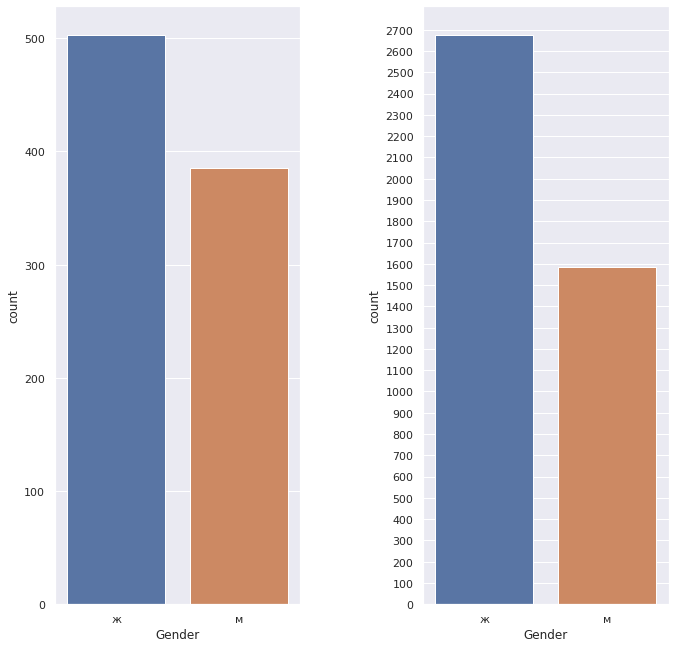

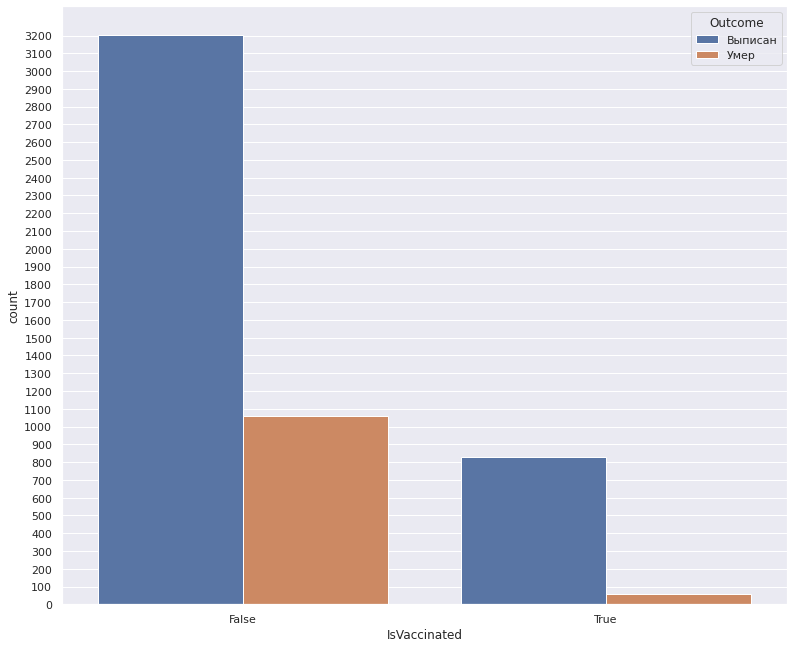

----------------------------------------------------
people with vacine
831 / 57
14.578947368421053
----------------------------------------------------
people without vacine
3204 / 1057
3.031220435193945
----------------------------------------------------


In [ ]:
task_2a()

In [ ]:
def task_5():
    data2 = task_1().dropna()
    grVac = data2[data2.IsVaccinated]
    grnonVac= data2[~data2.IsVaccinated]
    LVac = grVac.query('Outcome == "Выписан"').assign(LTher = (grVac.query('Outcome == "Выписан"').EndTher - grVac.query('Outcome == "Выписан"').StartTher).dt.days)
    LnonVac=grnonVac.query('Outcome == "Выписан"').assign(LTher = (grnonVac.query('Outcome == "Выписан"').EndTher - grnonVac.query('Outcome == "Выписан"').StartTher).dt.days)
    DVac=grVac.query('Outcome == "Умер"').assign(LTher = (grVac.query('Outcome == "Умер"').EndTher - grVac.query('Outcome == "Умер"').StartTher).dt.days)
    DnonVac=grnonVac.query('Outcome == "Умер"').assign(LTher = (grnonVac.query('Outcome == "Умер"').EndTher - grnonVac.query('Outcome == "Умер"').StartTher).dt.days)
    sns.displot(LVac,x='LTher',aspect=3,height=6,bins=43)
    plt.title("Дни проведённые в больнице у вакцинированных")
    plt.xlabel("Количество дней")
    plt.ylabel("Количество")
    plt.xticks(range(0,44))
    plt.xlim(0)
    plt.yticks(range(0,96,5))
    #sns.displot(LnonVac,x='LTher',aspect=3,height=6,bins=62)
    sns.displot(LnonVac[LnonVac.LTher < LVac.LTher.max()],x='LTher',aspect=3,height=6,bins=43)
    plt.title("Дни проведённые в больнице у невакцинированных")
    plt.xlabel("Количество дней")
    plt.ylabel("Количество")
    #plt.xticks(range(0,63))
    plt.xticks(range(0,44))
    plt.xlim(0)
    plt.yticks(range(0,271,10))
    plt.show()
    sns.displot(DVac,x='LTher',aspect=3,height=6,bins=35)
    plt.title("Дни проведённые в больнице у вакцинированных")
    plt.xlabel("Количество дней")
    plt.ylabel("Количество")
    plt.xticks(range(0,36))
    plt.xlim(0)
    plt.yticks(range(0,8,1))
    #__________________________
    DnonVac2=DnonVac.drop(4059)
    #__________________________
    sns.displot(DnonVac2,x='LTher',aspect=3,height=6,bins=66)
    plt.title("Дни проведённые в больнице у невакцинированных")
    plt.xlabel("Количество дней")
    plt.ylabel("Количество")
    plt.xticks(range(0,67))
    plt.xlim(0)
    plt.yticks(range(0,81,10))
    plt.show()
    print("Также был один, кто пробыл в больнице 109 дней")
    fig, ax = plt.subplots(figsize=(12,12))
    sns.violinplot(x='Outcome',y='Age',data=data2,gridsize=100)
    plt.title("Распределение возраста относительно исхода")
    plt.xlabel("Исход")
    plt.ylabel("Возраст")
    plt.yticks(range(0,111,5))
    plt.show()
    def non_outliers(col):
        Q3 = col.quantile(0.75)
        Q1 = col.quantile(0.25)
        d = (Q3 - Q1)*1.5
        return col.between(Q1 - d, Q3 + d)

    def del_outliers(df, col_name):
        return df[non_outliers(df[col_name])]
    fig, ax = plt.subplots(figsize=(11,11))

    WITH_OUTLIERS = False
    if WITH_OUTLIERS:
        _dat = pd.concat([DVac,DnonVac])
    else:
        _dat = pd.concat([del_outliers(DVac, 'LTher'),del_outliers(DnonVac, 'LTher')])
    sns.violinplot(x='IsVaccinated',y='LTher',data=_dat,gridsize=1000)
    plt.title("Распределение времени проведённого в больнице относительно вакцинации у умерших")
    plt.xlabel("Вакцинирован")
    plt.ylabel("Количество дней")
    if WITH_OUTLIERS:
        plt.yticks(range(0,111,5))
    plt.show()
    fig, ax = plt.subplots(figsize=(11,11))
    WITH_OUTLIERS = False
    if WITH_OUTLIERS:
        _dat = pd.concat([LVac,LnonVac])
    else:
        _dat = pd.concat([del_outliers(LVac, 'LTher'),del_outliers(LnonVac, 'LTher')])
    #_dat = _dat[non_outliers(_dat.LTher)]
    sns.violinplot(x='IsVaccinated',y='LTher',data=_dat,gridsize=1000)
    plt.title("Распределение времени проведённого в больнице относительно вакцинации у Выписанных")
    plt.xlabel("Вакцинирован")
    plt.ylabel("Количество дней")
    if WITH_OUTLIERS:
        plt.yticks(range(0,66,5))
    plt.show()

# 6

In [ ]:
def rot_xtick(ax, angle=45):
    """
    rotate labels for x
    """
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def write_label(ax, fmt='%g'):
    """
    write values on top of bars in barplot
    """
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt)

def resize(ax, new_size=(10, 10)):
    ax.figure.set_size_inches(*new_size)

def double_fig():
    f, axes = plt.subplots(1, 2)
    resize(axes[0], (20, 10))
    return axes

def get_vac_data(data):
    vac_data = data.groupby(['Vacin'])['Outcome']\
        .value_counts(normalize=True)\
        .mul(100)\
        .reset_index()\
        .set_axis(['Vacin', 'Outcome', 'Percentage'], axis=1)
    vac_row = data[data.IsVaccinated]\
        .groupby('Outcome')\
        .size()
    vac_row = vac_row.mul(100/vac_row.sum())\
        .rename('Percentage')\
        .reset_index()
    vac_row.insert(0, 'Vacin', 'Vacinated, total')
    vac_data = pd.concat([vac_data, vac_row, vac_data[vac_data.Vacin=='Нет']])\
        .reset_index()\
        .drop_duplicates(keep='last')
    
    return vac_data

def vaccine_vis(data):
    axes = double_fig()
    sns.countplot(x='Vacin', hue='Outcome', data=data, ax=axes[0], hue_order=['Умер', 'Выписан'])
    axes[0].set_title('Абсолютные цифры вакцинации')
    sns.barplot(x='Vacin', y='Percentage', hue='Outcome', hue_order=['Умер', 'Выписан'], data=get_vac_data(data), ax=axes[1])
    axes[1].set_title('Распределение исходов для каждой вакцины')
    for ax in axes:
        rot_xtick(ax)
    write_label(axes[0])
    write_label(axes[1], fmt='%.2f')
    
    axes[1].legend(loc='upper left')

In [ ]:
def get_death_rate(data):
    return data.groupby(['IsVaccinated', 'Age'])['Outcome']\
        .value_counts(normalize=True)\
        .mul(100)\
        .reset_index()\
        .set_axis(['IsVaccinated', 'Age', 'Outcome', 'DeathRate'], axis=1)\
        .query('Outcome == "Умер"')

def age_and_gender_vis(data, roll_size=7):
    """
    roll_size = number of neighbours from which mean will be taken, makes line in death rate graph more smooth
    """
    axes = double_fig()
    sns.violinplot(x='Outcome', y='Age', hue='Gender', split=True, data=data, ax=axes[0])
    axes[0].set_title('Распределение возрастов в зависимости от исхода и пола')
    
    dr = get_death_rate(data)
    sns.scatterplot(x='Age', y='DeathRate', hue='IsVaccinated', data=dr, ax=axes[1])
    for cond in dr.IsVaccinated, ~dr.IsVaccinated:
        dr.DeathRate[cond] = dr[cond]\
                                .rolling(roll_size, min_periods=1, on='Age')\
                                .mean()\
                                .DeathRate
    sns.lineplot(x='Age', y='DeathRate', hue='IsVaccinated', data=dr, ax=axes[1])

    axes[1].set_title('Смертность для возрастов в зависимости от факта вакцинации')
    axes[1].set_ylabel('Смертность, %')

In [ ]:
def outliers_num(col):
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    d = (Q3 - Q1)*1.5
    return ((Q1 - d > col) | (col > Q3 + d)).sum()

def d_f_indicators_vis(data):
    print(f'number of ouliers in: F - {outliers_num(data.Result_F)}, D - {outliers_num(data.Result_D)}')
    axes = double_fig()
    sns.boxenplot(x='Outcome', y='Result_F', data=data, showfliers=False, ax=axes[0])
    axes[0].set_title('Индикатор F')
    sns.boxenplot(x='Outcome', y='Result_D', data=data, showfliers=False, ax=axes[1])
    axes[1].set_title('Индикатор D')

In [ ]:
def severity_vis(data):
    repl_dict = {cat : re.match(r'.*\((.*)\).*', cat).group(1) for cat in data.Ther.cat.categories}
    data0 = data.assign(Ther=data.Ther\
                                .replace(repl_dict)\
                                .astype('category'))
    data1 = data0.groupby(['IsVaccinated', 'Ther'])['Outcome']\
                 .value_counts(normalize=True)\
                 .mul(100)\
                 .reset_index()\
                 .set_axis(['IsVaccinated', 'Ther', 'Outcome', 'Percentage'], axis=1)
    data2 = data0.groupby('IsVaccinated')['Ther']\
                 .value_counts(normalize=True)\
                 .mul(100)\
                 .reset_index()\
                 .set_axis(['Is vaccinated', 'Ther', 'Percentage'], axis=1)
    x_order = ['среднетяжелое течение', 'тяжелое течение', 'крайне тяжелое течение']

    axes = double_fig()
    sns.barplot(x='Ther', y='Percentage', hue='IsVaccinated', data=data1.query('Outcome == "Умер"'), order=x_order, ax=axes[0])
    #sns.barplot(x='Ther', y='Percentage', hue='Outcome', data=data1, order=x_order, ax=axes[0], hue_order=['Умер', 'Выписан'])
    axes[0].set_title('Смертность в зависимости от тяжести и факта вакцинации')
    sns.barplot(x='Is vaccinated', y='Percentage', hue='Ther', hue_order=x_order, data=data2, ax=axes[1])#, hue_order=['Умер', 'Выписан'])
    axes[1].set_title('Тяжесть в зависимости от факта вакцинации')
    rot_xtick(axes[0])
    for ax in axes:
        write_label(ax, fmt='%.2f')

In [ ]:
def task_6():
    data = task_1()
    vaccine_vis(data)
    age_and_gender_vis(data)
    d_f_indicators_vis(data)
    severity_vis(data)

In [ ]:
task_1().sample(10)

Number of NaNs in indicators: F - 872, D - 895


,CaseID,Indicator_D,Result_D,ResultDate_F,IDS,TakingDate_F,Indicator_F,Result_F,StartTher,EndTher,Gender,Age,Ther,Outcome,Vacin,IsVaccinated
10018,382781,NaN,NaN,2021-09-13,924424.0,2021-09-12,Ферритин,1969.00,2021-09-12,2021-09-13,м,30.0,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,False
6741,385738,D-димер нг/мл,957.7,2021-11-19,124498.0,2021-11-18,Ферритин,727.30,2021-11-18,2021-12-03,ж,74.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
5442,384160,D-димер нг/мл,790.6,2021-10-12,965939.0,2021-10-12,Ферритин,1663.00,2021-10-11,2021-10-19,ж,87.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
8381,387959,D-димер нг/мл,171.4,2022-01-17,199693.0,2022-01-16,Ферритин,261.00,2022-01-16,2022-01-31,м,67.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Спутник V,True
5383,384090,D-димер нг/мл,619.5,2021-10-11,963829.0,2021-10-11,Ферритин,324.50,2021-10-09,2021-10-14,ж,28.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
5692,384451,D-димер нг/мл,177.0,2021-10-19,978830.0,2021-10-16,Ферритин,983.50,2021-10-16,2021-10-25,ж,61.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
7914,387324,D-димер нг/мл,306.0,2022-01-03,180849.0,2021-12-30,Ферритин,1273.00,2021-12-30,2022-01-12,ж,68.0,ИНФ (среднетяжелое течение) с ЛП без терапии,Выписан,Спутник V,True
5342,384037,D-димер нг/мл,242.6,2021-10-11,963764.0,2021-10-08,Ферритин,44.74,2021-10-08,2021-10-11,ж,20.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,False
2120,380019,D-димер нг/мл,3000.0,2021-07-01,841169.0,2021-07-01,Ферритин,1498.00,2021-07-01,2021-07-13,м,67.0,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,False
6480,385424,D-димер нг/мл,2024.0,2021-11-10,114092.0,2021-11-09,Ферритин,222.30,2021-11-09,2021-11-26,м,43.0,ИНФ (среднетяжелое течение) без ЛП и терапии,Умер,Нет,False


Number of NaNs in indicators: F - 872, D - 895
62.93693693693694
66.33959164515372


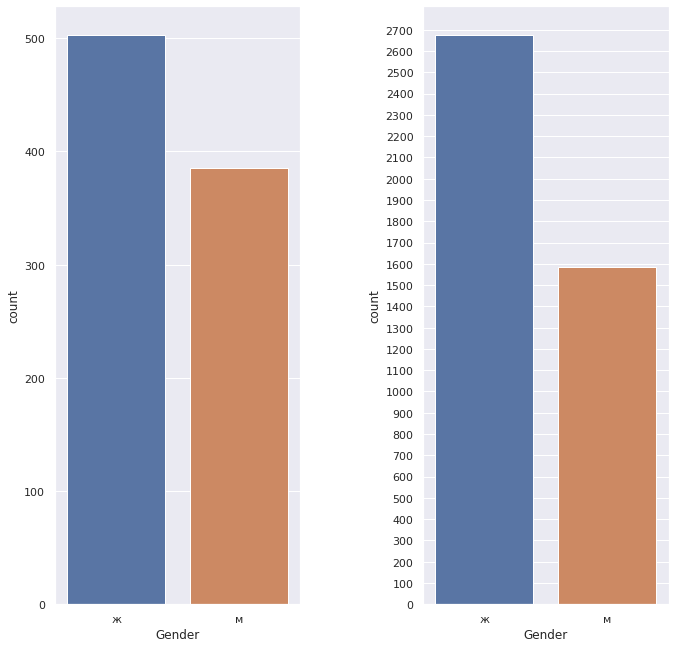

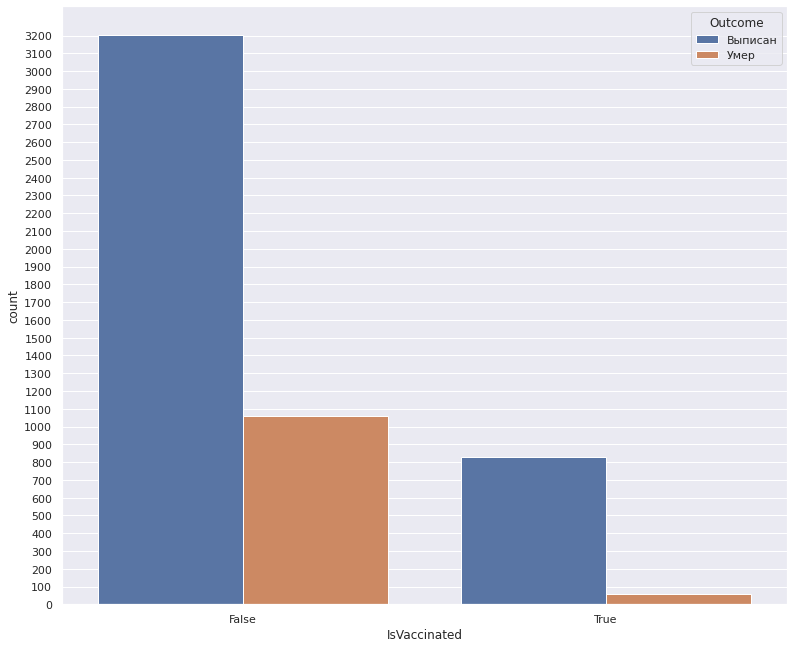

----------------------------------------------------
people with vacine
831 / 57
14.578947368421053
----------------------------------------------------
people without vacine
3204 / 1057
3.031220435193945
----------------------------------------------------


In [ ]:
task_2a()

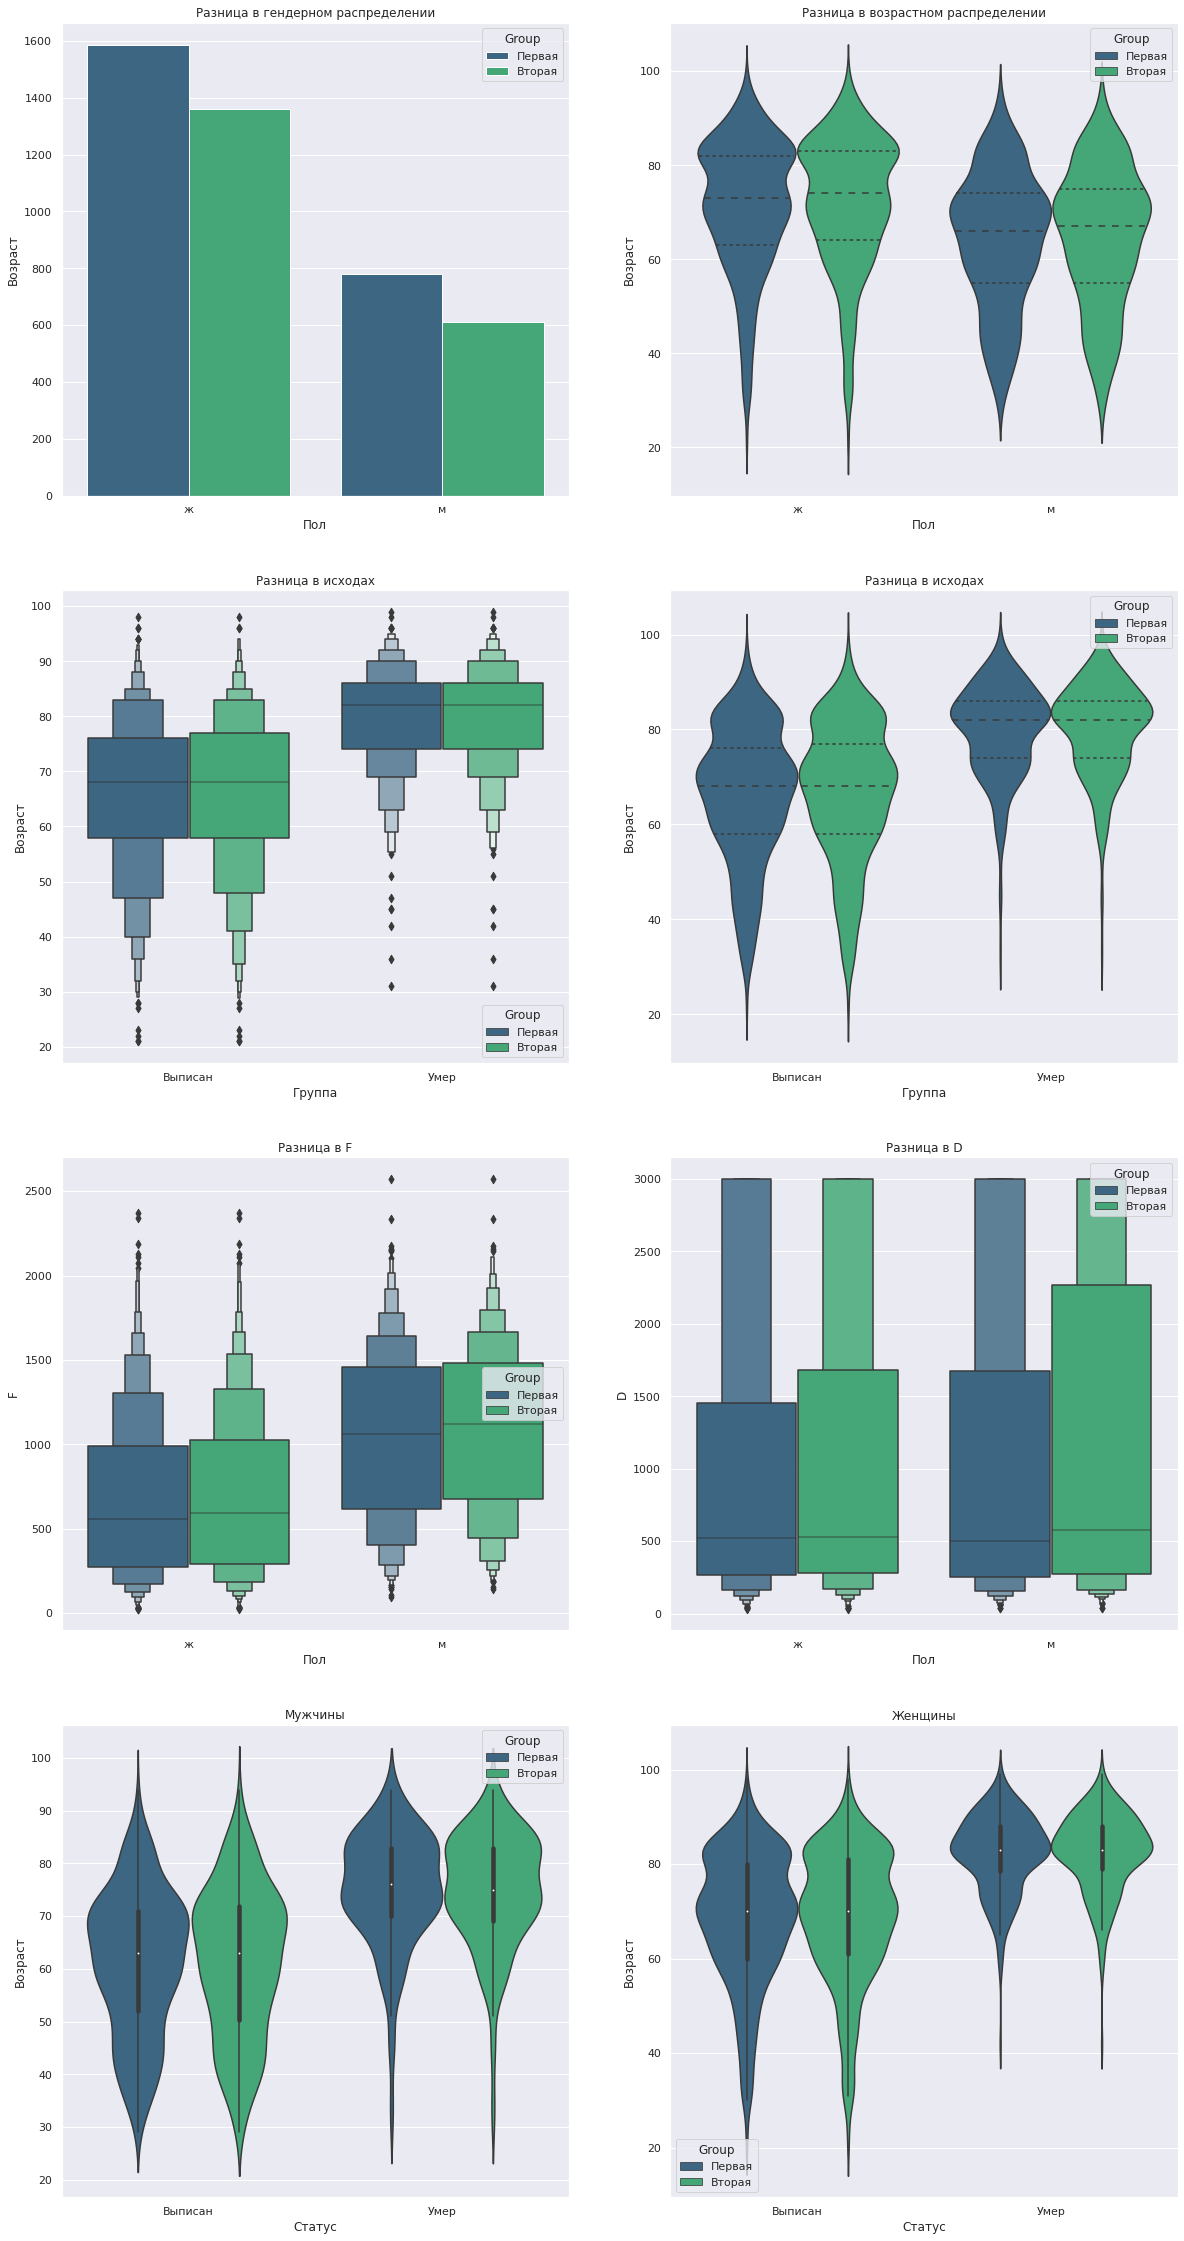

In [ ]:
task_4()

Number of NaNs in indicators: F - 872, D - 895


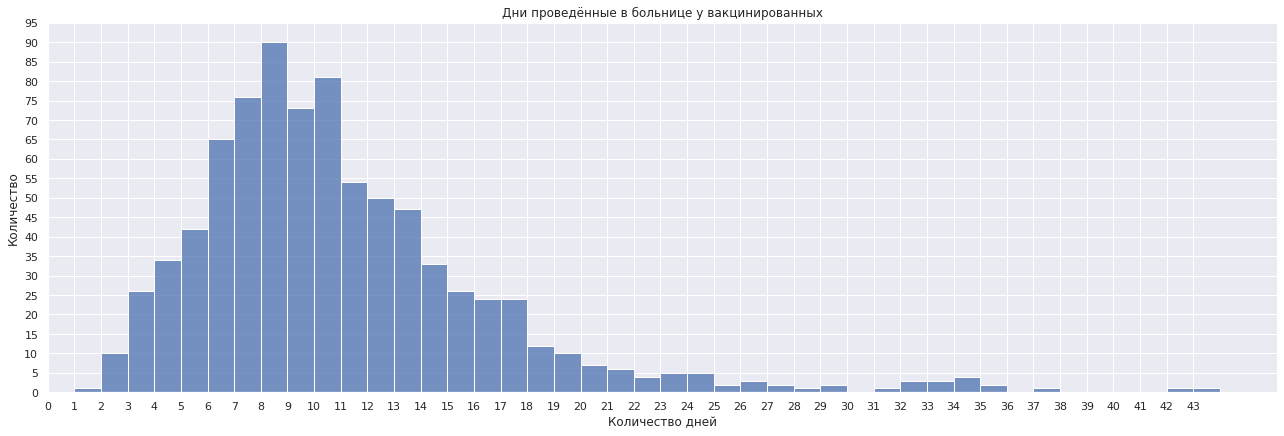

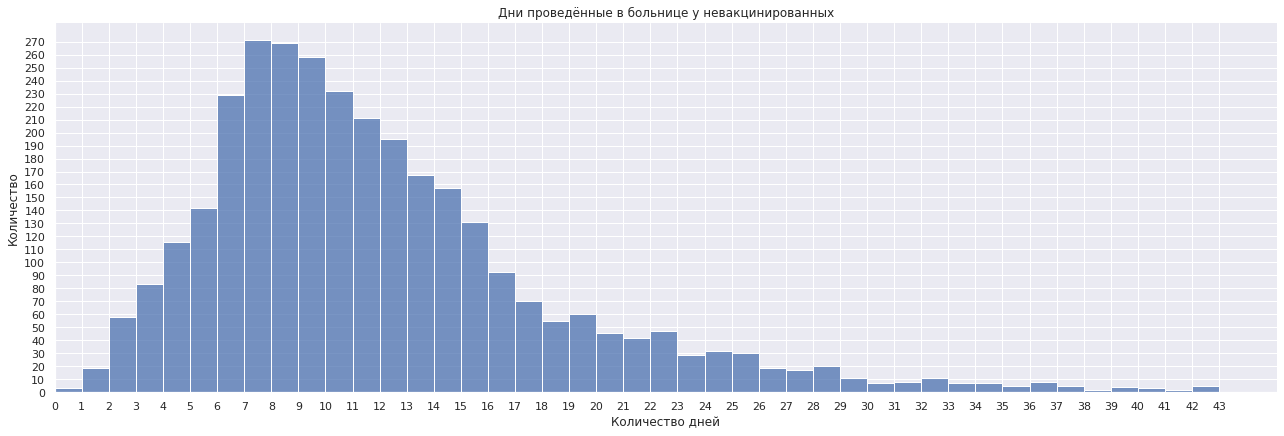

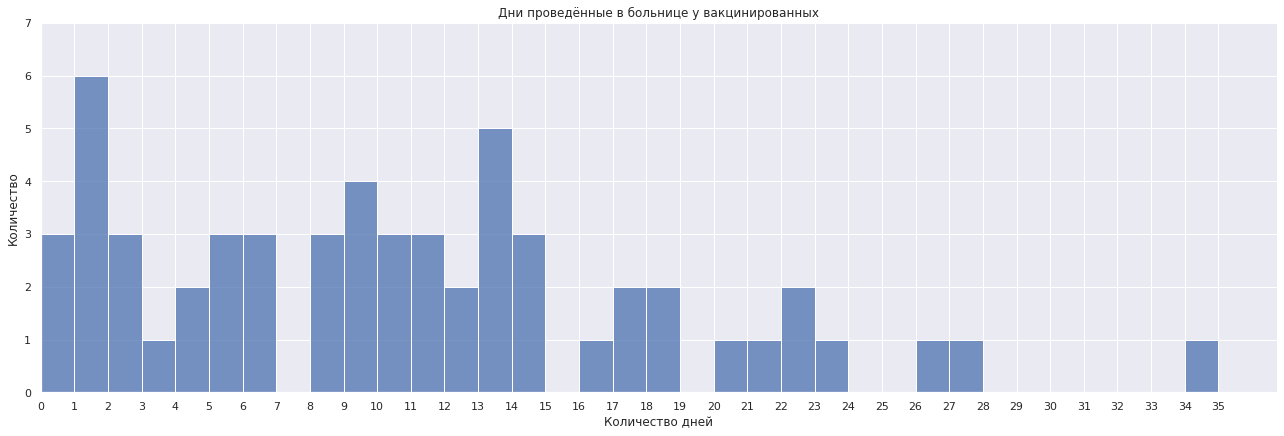

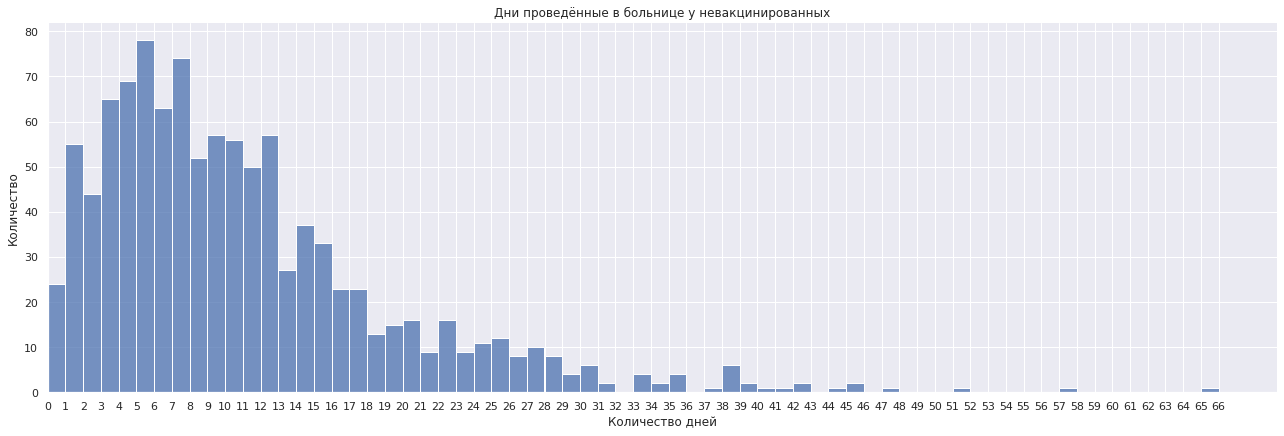

Также был один, кто пробыл в больнице 109 дней


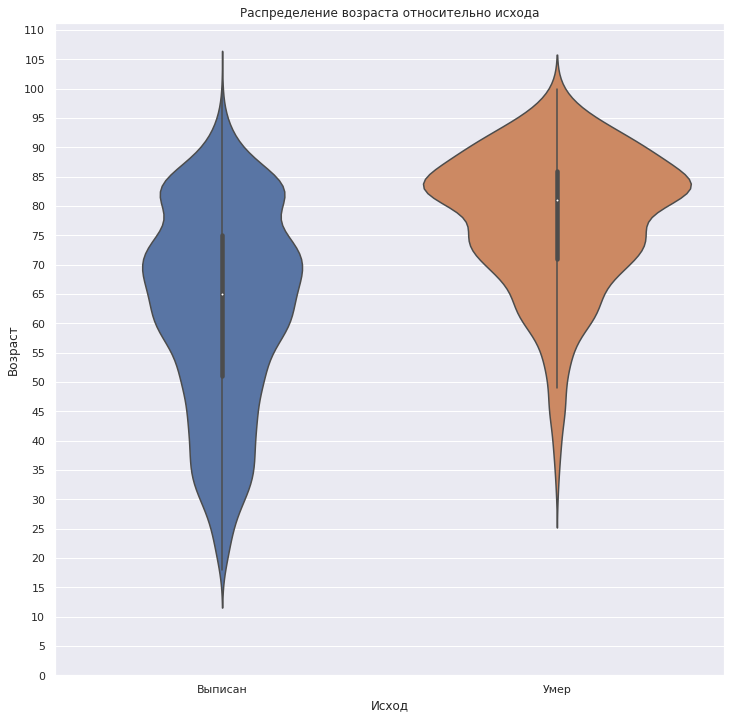

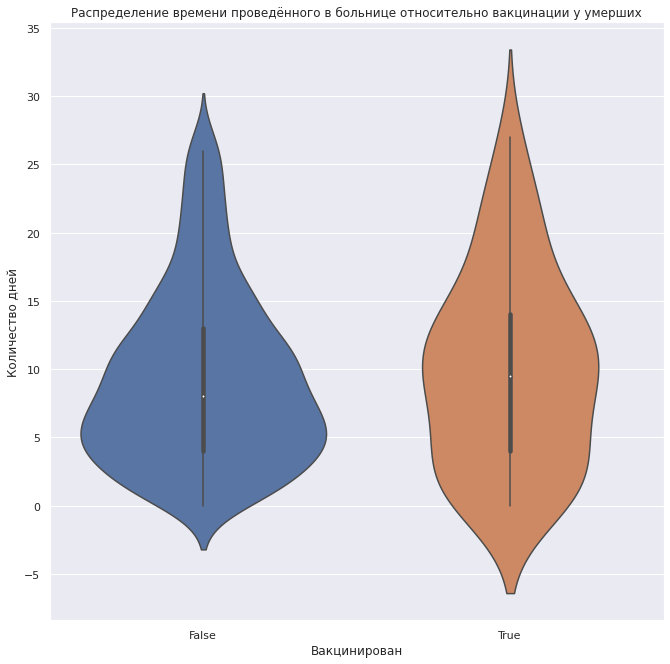

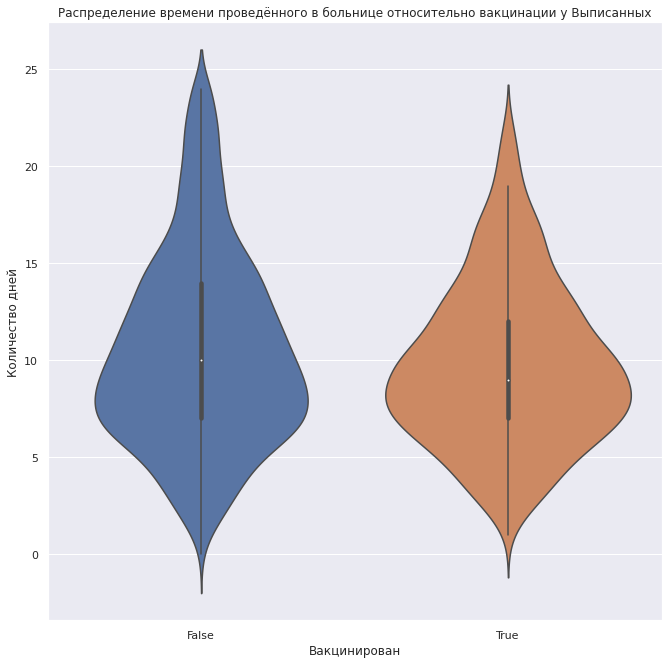

In [ ]:
task_5()

Number of NaNs in indicators: F - 872, D - 895
number of ouliers in: F - 10, D - 34


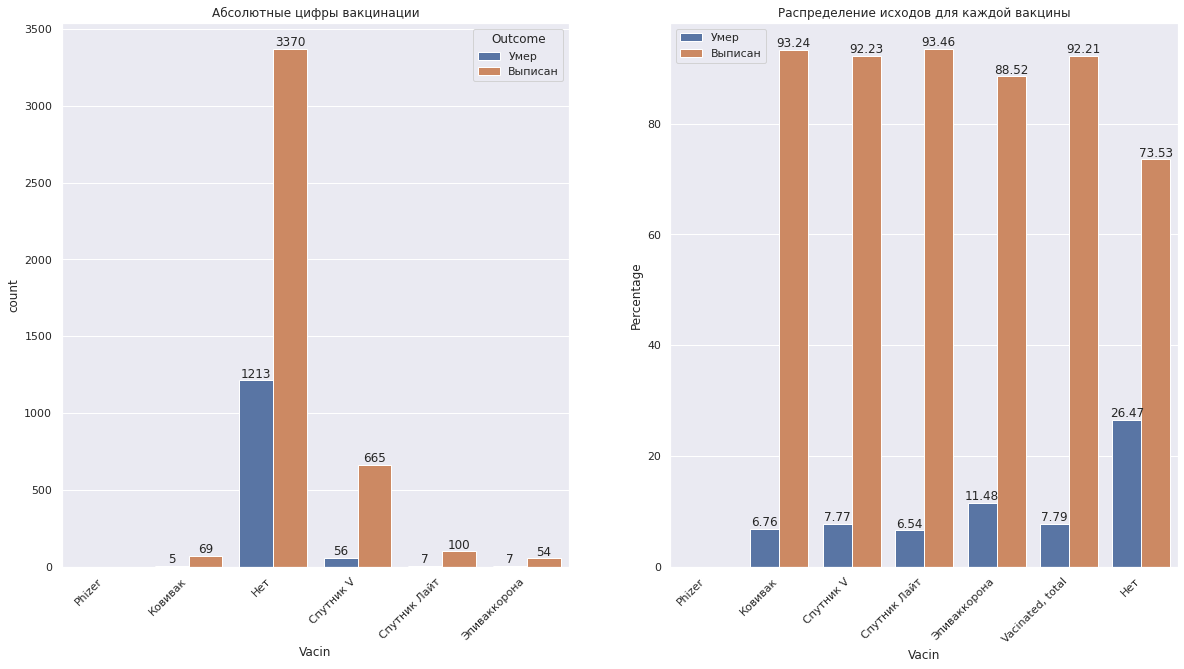

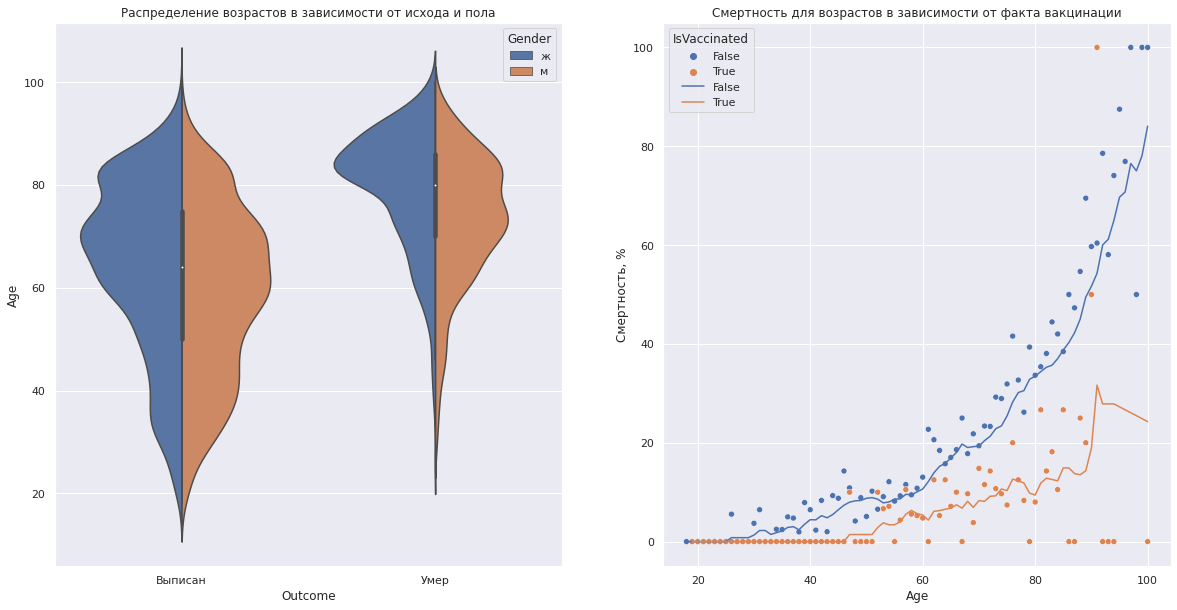

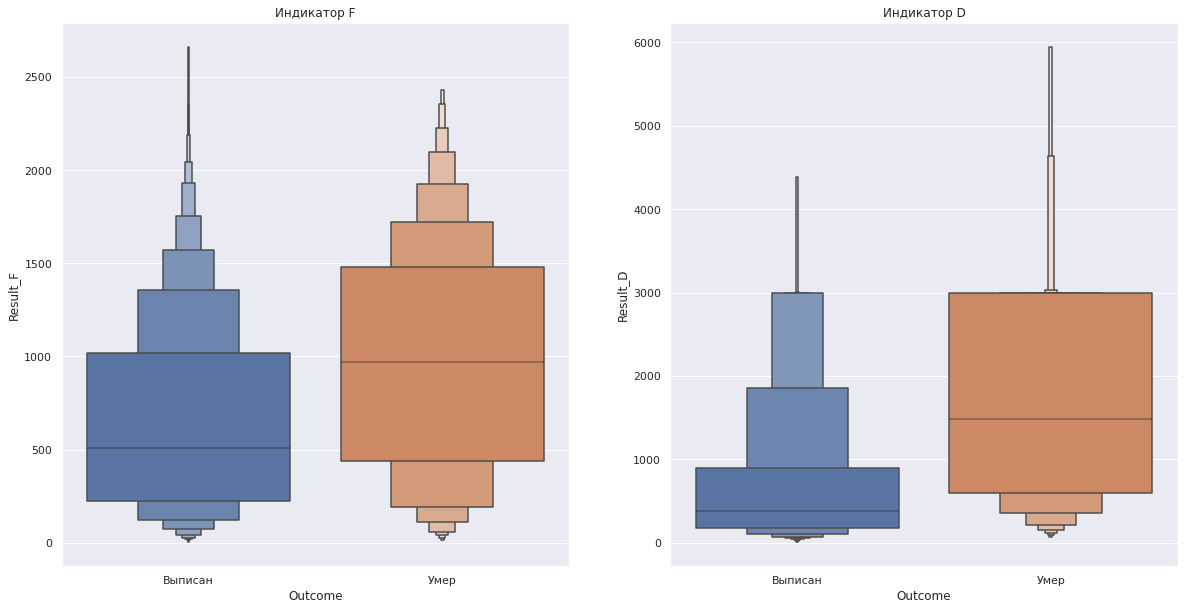

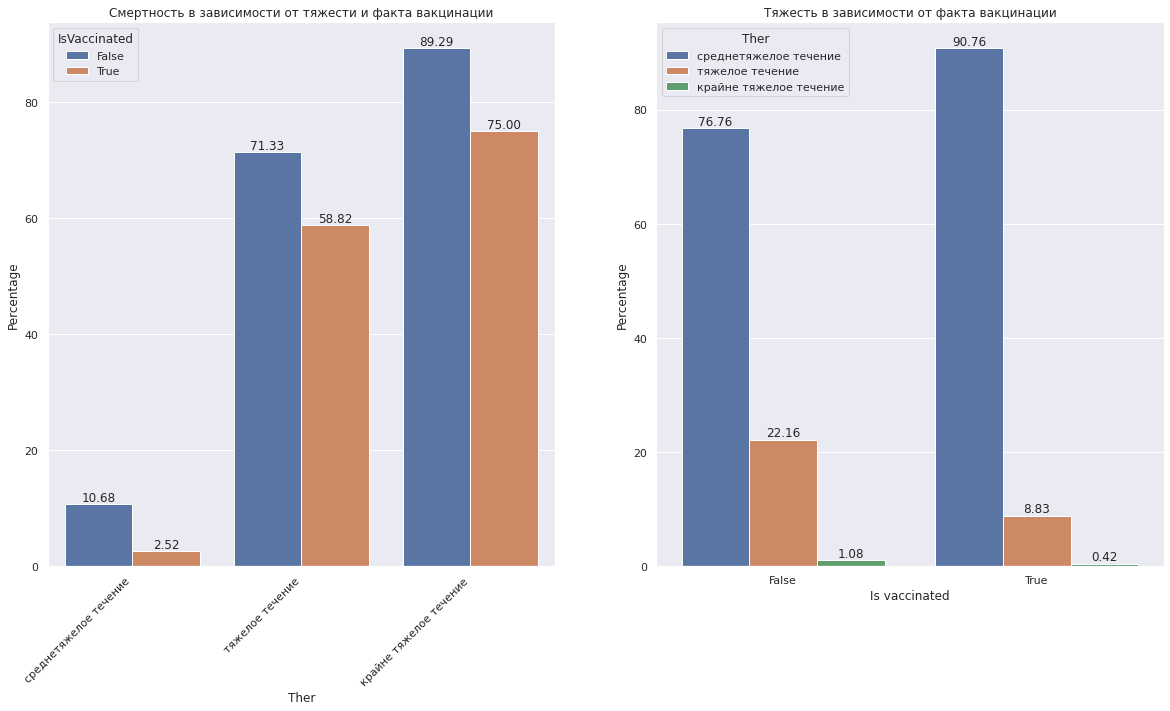

In [ ]:
task_6()